In [1]:
import numpy as np
from brian2 import *
from brian2tools import *

WARNING    /home/alteska/anaconda3/envs/brian_opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
 [py.warnings]


In [2]:
dt = 0.01 * ms
defaultclock.dt = dt
# Generate a step-current input and an "experimental" voltage trace
input_current1 = np.hstack([ np.ones(int(5*ms/dt))*5, np.zeros(2*int(5*ms/dt))])* 5 *nA
input_current0 = np.hstack([np.zeros(int(5*ms/dt)), np.ones(int(5*ms/dt))*10, np.zeros(int(5*ms/dt))]) * 5 * nA

input_current2 = np.stack((input_current0, input_current1))
I = TimedArray(input_current0, dt=dt)

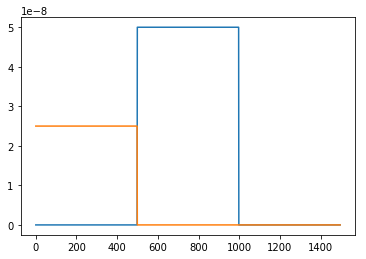

In [3]:
plot(input_current0)
plot(input_current1)

In [4]:
# C = 1*nF
# gL = 30*nS
EL = -70*mV
VT = -50*mV
DeltaT = 2*mV
eqs = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I(t))/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''')

In [5]:
group = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')
group.v = -70 *mV
group.set_states({'gL': [30*nS], 'C':[1*nF]})

In [6]:
monitor0 = StateMonitor(group, 'v', record=True)
smonitor0  = SpikeMonitor(group)

In [7]:
run(60*ms)

In [8]:
voltage = monitor0.v[0]/mV
out_spikes0 = getattr(smonitor0, 't') / ms
print(out_spikes0)

[5.39 5.8  6.21 6.62 7.03 7.44 7.85 8.26 8.67 9.08 9.49 9.9 ]


In [9]:
start_scope()
I = TimedArray(input_current1, dt=dt)
group = NeuronGroup(1, eqs,
                    threshold='v > -50*mV',
                    reset='v = -70*mV',
                    method='exponential_euler')
group.v = -70 *mV
group.set_states({'gL': [30*nS], 'C':[1*nF]})

In [10]:
monitor1 = StateMonitor(group, 'v', record=True)
smonitor1  = SpikeMonitor(group)

In [11]:
run(60*ms)
out_spikes1 = getattr(smonitor1, 't') / ms
print(out_spikes1)

[0.8  1.61 2.42 3.23 4.04 4.85]


In [12]:
inp_trace0 = np.array([input_current0])
inp_trace1 = np.array([input_current1])

In [13]:
inp_trace = np.concatenate((inp_trace0, inp_trace1))
inp_trace

array([[0.0e+00, 0.0e+00, 0.0e+00, ..., 0.0e+00, 0.0e+00, 0.0e+00],
       [2.5e-08, 2.5e-08, 2.5e-08, ..., 0.0e+00, 0.0e+00, 0.0e+00]])

In [14]:
out_spikes = np.array(([out_spikes0,out_spikes1]))
out_spikes

array([array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ]),
       array([0.8 , 1.61, 2.42, 3.23, 4.04, 4.85])], dtype=object)

### Generate Spikes

In [15]:
start_scope()
eqs_fit = Equations('''
    dv/dt = (gL*(EL-v)+gL*DeltaT*exp((v-VT)/DeltaT) + I)/C : volt
    gL: siemens (constant)
    C: farad (constant)
    ''',
    EL = -70*mV,
    VT = -50*mV,
    DeltaT = 2*mV,
#     C=1*nF
   )

n_opt = NevergradOptimizer()
metric = GammaFactor(100*ms, dt)

In [16]:
TR = fit_spikes(model=eqs_fit, input_var='I',
                input=inp_trace * amp, output=out_spikes, dt=dt,
                n_rounds=1, n_samples=4, optimizer=n_opt, metric=metric,
                threshold='v > -50*mV',
                reset='v = -70*mV',
                method='exponential_euler',
                param_init={'v': -70*mV},
                gL=[20*nS, 50*nS],
                C = [0.5*nS, 1.5*nS]
                )

d_param {'C': array([9.64148034e-10, 9.64148034e-10, 7.46224417e-10, 7.46224417e-10,
       7.79827424e-10, 7.79827424e-10, 1.01675980e-09, 1.01675980e-09]), 'gL': array([2.98221450e-08, 2.98221450e-08, 3.62295441e-08, 3.62295441e-08,
       4.01828281e-08, 4.01828281e-08, 4.61787066e-08, 4.61787066e-08])}


In [17]:
TR

{0: array([5.37, 5.76, 6.15, 6.54, 6.93, 7.32, 7.71, 8.1 , 8.49, 8.88, 9.27,
        9.66]) * msecond,
 1: array([0.78, 1.57, 2.36, 3.15, 3.94, 4.73]) * msecond,
 2: array([5.29, 5.6 , 5.91, 6.22, 6.53, 6.84, 7.15, 7.46, 7.77, 8.08, 8.39,
        8.7 , 9.01, 9.32, 9.63, 9.94]) * msecond,
 3: array([0.6 , 1.21, 1.82, 2.43, 3.04, 3.65, 4.26, 4.87]) * msecond,
 4: array([5.3 , 5.62, 5.94, 6.26, 6.58, 6.9 , 7.22, 7.54, 7.86, 8.18, 8.5 ,
        8.82, 9.14, 9.46, 9.78]) * msecond,
 5: array([0.63, 1.27, 1.91, 2.55, 3.19, 3.83, 4.47]) * msecond,
 6: array([5.4 , 5.82, 6.24, 6.66, 7.08, 7.5 , 7.92, 8.34, 8.76, 9.18, 9.6 ]) * msecond,
 7: array([0.82, 1.65, 2.48, 3.31, 4.14, 4.97]) * msecond}

In [18]:
traces = []
for i in np.arange(len(TR)):
    trace = TR[i] / ms
    traces.append(trace)

In [19]:
traces

[array([5.37, 5.76, 6.15, 6.54, 6.93, 7.32, 7.71, 8.1 , 8.49, 8.88, 9.27,
        9.66]),
 array([0.78, 1.57, 2.36, 3.15, 3.94, 4.73]),
 array([5.29, 5.6 , 5.91, 6.22, 6.53, 6.84, 7.15, 7.46, 7.77, 8.08, 8.39,
        8.7 , 9.01, 9.32, 9.63, 9.94]),
 array([0.6 , 1.21, 1.82, 2.43, 3.04, 3.65, 4.26, 4.87]),
 array([5.3 , 5.62, 5.94, 6.26, 6.58, 6.9 , 7.22, 7.54, 7.86, 8.18, 8.5 ,
        8.82, 9.14, 9.46, 9.78]),
 array([0.63, 1.27, 1.91, 2.55, 3.19, 3.83, 4.47]),
 array([5.4 , 5.82, 6.24, 6.66, 7.08, 7.5 , 7.92, 8.34, 8.76, 9.18, 9.6 ]),
 array([0.82, 1.65, 2.48, 3.31, 4.14, 4.97])]

In [20]:
out_spikes

array([array([5.39, 5.8 , 6.21, 6.62, 7.03, 7.44, 7.85, 8.26, 8.67, 9.08, 9.49,
       9.9 ]),
       array([0.8 , 1.61, 2.42, 3.23, 4.04, 4.85])], dtype=object)

In [21]:
for os in out_spikes:
    print(os)

[5.39 5.8  6.21 6.62 7.03 7.44 7.85 8.26 8.67 9.08 9.49 9.9 ]
[0.8  1.61 2.42 3.23 4.04 4.85]


## Calculate the Gamma Factor

In [22]:
def firing_rate(spikes):
    '''
    Rate of the spike train.
    '''
    if len(spikes)<2:
        return NaN
    return (len(spikes) - 1) / (spikes[-1] - spikes[0])

In [23]:
def get_gamma_factor(source, target, delta, dt):
    """Calculate gamma factor between source and tagret spike trains"""
    source = array(source)
    target = array(target)
    target_rate = firing_rate(target) * Hz

    source = array(rint(source / dt), dtype=int)
    target = array(rint(target / dt), dtype=int)
    delta_diff = int(rint(delta / dt))

    source_length = len(source)
    target_length = len(target)

    if (source_length > 1):
        bins = .5 * (source[1:] + source[:-1])
        indices = digitize(target, bins)
        diff = abs(target - source[indices])
        matched_spikes = (diff <= delta_diff)
        coincidences = sum(matched_spikes)
    else:
        indices = [amin(abs(source - target[i])) <= delta_diff for i in xrange(target_length)]
        coincidences = sum(indices)

    # Normalization of the coincidences count
    NCoincAvg = 2 * delta * target_length * target_rate
    norm = .5*(1 - 2 * target_rate * delta)
    gamma = (coincidences - NCoincAvg)/(norm*(source_length + target_length))
    return gamma

In [24]:
Ntraces, Nsteps = np.shape(inp_trace)
Nsteps, Ntraces

(1497, 2)

In [60]:
    Ntraces = np.shape(out_spikes)
Ntraces

(2,)

In [39]:
n_samples = 5

In [61]:
traces

[array([5.37, 5.76, 6.15, 6.54, 6.93, 7.32, 7.71, 8.1 , 8.49, 8.88, 9.27,
        9.66]),
 array([0.78, 1.57, 2.36, 3.15, 3.94, 4.73]),
 array([5.29, 5.6 , 5.91, 6.22, 6.53, 6.84, 7.15, 7.46, 7.77, 8.08, 8.39,
        8.7 , 9.01, 9.32, 9.63, 9.94]),
 array([0.6 , 1.21, 1.82, 2.43, 3.04, 3.65, 4.26, 4.87]),
 array([5.3 , 5.62, 5.94, 6.26, 6.58, 6.9 , 7.22, 7.54, 7.86, 8.18, 8.5 ,
        8.82, 9.14, 9.46, 9.78]),
 array([0.63, 1.27, 1.91, 2.55, 3.19, 3.83, 4.47]),
 array([5.4 , 5.82, 6.24, 6.66, 7.08, 7.5 , 7.92, 8.34, 8.76, 9.18, 9.6 ]),
 array([0.82, 1.65, 2.48, 3.31, 4.14, 4.97])]

In [44]:
gamma_factors = []

for i in np.arange(Ntraces):
    temp_out = out_spikes[i]
    temp_traces = traces[i::Ntraces]
    
    for trace in temp_traces:
        gf = get_gamma_factor(trace, temp_out, 60*ms, dt)
        gamma_factors.append(gf)
        print(trace, gf)

[5.37 5.76 6.15 6.54 6.93 7.32 7.71 8.1  8.49 8.88 9.27 9.66] -0.06034482758620689
[5.29 5.6  5.91 6.22 6.53 6.84 7.15 7.46 7.77 8.08 8.39 8.7  9.01 9.32
 9.63 9.94] 0.04926108374384237
[5.3  5.62 5.94 6.26 6.58 6.9  7.22 7.54 7.86 8.18 8.5  8.82 9.14 9.46
 9.78] 0.1558109833971903
[5.4  5.82 6.24 6.66 7.08 7.5  7.92 8.34 8.76 9.18 9.6 ] 0.3058470764617692
[0.78 1.57 2.36 3.15 3.94 4.73] 0.4130434782608696
[0.6  1.21 1.82 2.43 3.04 3.65 4.26 4.87] 0.1863354037267081
[0.63 1.27 1.91 2.55 3.19 3.83 4.47] 0.02006688963210701
[0.82 1.65 2.48 3.31 4.14 4.97] 0.4130434782608696


In [45]:
gamma_factors

[-0.06034482758620689,
 0.04926108374384237,
 0.1558109833971903,
 0.3058470764617692,
 0.4130434782608696,
 0.1863354037267081,
 0.02006688963210701,
 0.4130434782608696]

In [49]:
int(len(features)/Ntraces), Ntraces

(4, 2)

In [55]:
features = gamma_factors
feat_arr = reshape(array(features), (Ntraces, int(len(features)/Ntraces)))

feat_arr        

array([[-0.06034483,  0.04926108,  0.15581098,  0.30584708],
       [ 0.41304348,  0.1863354 ,  0.02006689,  0.41304348]])

In [56]:
mean(feat_arr, axis=0)

array([0.17634933, 0.11779824, 0.08793894, 0.35944528])